# I/O sequencing with `NidaqSequencer`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qdlutils.hardware.nidaq.synchronous.nidaqsequencer import NidaqSequencer
from qdlutils.hardware.nidaq.synchronous.nidaqsequencerinputgroup import *
from qdlutils.hardware.nidaq.synchronous.nidaqsequenceroutputgroup import *

First we need to define the hardware inputs and outputs to supply to the sequencer. We do this by
creating dictionaries describing the input and outputs respectively. The items within this dictionary
describe groups of inputs/outputs of the same type (e.g. analog voltage inputs). This grouping is done
because most DAQ boards only have a single hardware clock for each type of I/O (e.g. analog output 
or digital input). In situations where a DAQ board supports multiple hardware clocks the tasks can 
further separated as desired. Note that the clock limitations applies whenever the channel types
are the same, independent of the specific measurement type (e.g. voltage, current, etc.).  As a
consequence, new `NidaqSequencerInputGroup`s and `NidaqSequencerOutputGroup`s should be developed if
mixed measurement types are required.

In the example provided here, we have two analog inputs connected to the physical channels `Dev1/ai1`
and `Dev1/ai2` and an edge counter on physical port `Dev1/PFI0` managed by the virtual channel `Dev1/ctr2`.
The output signals are sent through two analog voltage outputs on physical channels `Dev1/ao0` and
`Dev1/ao1`. Physically, we have directly connected the input and outputs with `Dev1/ao0 -> Dev1/ai1`
and `Dev1/ao1 -> Dev1/ai2`. The counter is connected to an SPCM which continually sends TTL pulses
to the counter as photons are detected (in this example, the counts are a comination of room light
and dark counts).

The names identifying individual I/O channels in this case are generic names, e.g. `ai_voltage_1`.
However, in a practical situation you should name these channels descriptively to identify the 
specific hardware you are controlling/reading from (e.g. `spcm`, `scan_laser`, etc.). The names of
the I/O source groups are primarily used internally but are referenced if errors occur.

In [2]:
inputs = {
    # Create a group of analog voltage inputs
    'ai_voltage_group' : NidaqSequencerAIVoltageGroup(
        channels_config = {
            'ai_voltage_1': {'device': 'Dev1', 'channel': 'ai1'},
            'ai_voltage_2': {'device': 'Dev1', 'channel': 'ai2'}
        }
    ),
    # Create a group for a counter
    'ci_edge_group' : NidaqSequencerCIEdgeGroup(
        channels_config  = {
            'ci_edge' : {'device': 'Dev1', 'channel': 'ctr2', 'terminal': 'PFI0'}
        },
    )
}

In [3]:
outputs = {
    'ao_voltage_group' : NidaqSequencerAOVoltageGroup(
        channels_config = {
            'ao_voltage_1': {'device': 'Dev1', 'channel': 'ao0', 'min': -3, 'max': 3},
            'ao_voltage_2': {'device': 'Dev1', 'channel': 'ao1', 'min': -3, 'max': 3}
        }
    ),
}

Now create the sequencer to utilize these I/O sources. The clock device, channel, and terminal
designate on which device and on which terminal the clock signal is generated. The clock signal is
generically output on the specified terminal for synching hardware not directly controllable by the
DAQ (e.g. serial connections, etc.)

In [4]:
sequencer = NidaqSequencer(
    inputs=inputs,
    outputs=outputs,
    clock_device='Dev1',
    clock_channel='ctr0',
    clock_terminal='PFI12',
)

We can now generate data to write during the sequence. In this case we write a cosine and sine on the
two voltage channels with a tunable sample rate and sequence time.

In [5]:
# Number of samples in the sequence
n_samples = 128

# Total sequence time in seconds
sequence_time = 2

# Rate of samples per second
sample_rate = n_samples / sequence_time

# Write the data to a dictionary to configure the sequencer, keys should match the names of the 
# channels provided during instantiation of the outputs.
x = np.linspace(0,1,n_samples)
output_data = {
    'ao_voltage_1' : np.cos(2*np.pi*x), 
    'ao_voltage_2' : np.sin(2*np.pi*x),
}

We now need to define the sequence parameters:

- Specifically we need to define `inputs_samples`
which describes the number of samples to be read out by each input source (given as a key-value pair
in a dicitonary). The keys must refer to individual channels specified in the inputs.

- The `readout_delays` similarly indicate the delay before the start of data collection. In practice, data
is simply collected through the entire sequence and only the data after the delay is returned or stored
in memory.

- Finally, the `soft_start` determines if the given output sources should be set to their initial value
before executing the sequence. NIDAQ usually leaves the channel at the last write value and so the 
first sample in the sequence can be inconsistent depending on what was last written. Soft start is
not strictly necessary when the sequence is periodic.

In [6]:
# Defines the number of samples to record on each source. All input sources should be defined.
input_samples = {
    'ai_voltage_1' : n_samples,
    'ai_voltage_2' : n_samples,
    'ci_edge' : n_samples
}

# Defines the number of cycles to delay readout on a given input channel, only those with non-zero
# delays need to be defined.
readout_delays = {
    'ai_voltage_1' : 32,
    'ci_edge' : 16
}

# Defines if the input sources should be soft-started, assumes False if not provided.
soft_start = {
    'ao_voltage_1' : True # Soft starts only 'ao_voltage_1'
}

We can then check how the sequence will look when we run it. This is a convenience function and does
not have any affect on the sequencer.

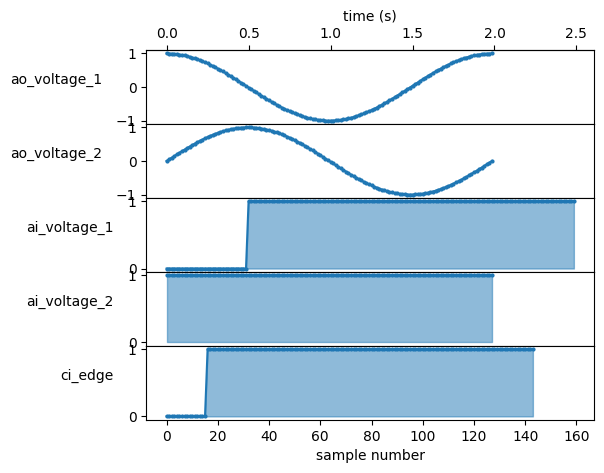

In [7]:
fig = sequencer.check_sequence(
    clock_rate=sample_rate,
    output_data=output_data,
    input_samples=input_samples,
    readout_delays=readout_delays
)

If the sequence looks good then we can actually run it (it is not required to check in advance)

In [8]:
sequencer.run_sequence(
    clock_rate=sample_rate,
    output_data=output_data,
    input_samples=input_samples,
    readout_delays=readout_delays,
    soft_start=soft_start,
    timeout=2*sequence_time # Should be larger than the expected sequence time including readout delays, 
                            # here 2x for simplicity but generally should be more precise.
)

Get the data from the sources. While there are optional parameters simply calling the method as such
will get data from all input/output soruces. The data is kept in a dictionary with key matching the
name of the source.

In [9]:
# Get the results
results = sequencer.get_data()
print(results.keys())

dict_keys(['ai_voltage_1', 'ai_voltage_2', 'ci_edge', 'ao_voltage_1', 'ao_voltage_2'])


Now process and plot the data to verify results

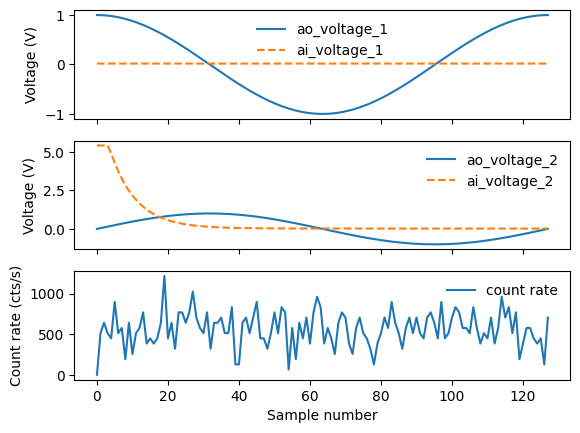

In [10]:
# Process the results
output_voltage_1 = results['ao_voltage_1']
output_voltage_2 = results['ao_voltage_2']
input_voltage_1 = results['ai_voltage_1']
input_voltage_2 = results['ai_voltage_2']
raw_counts = results['ci_edge']
# Need to conver the raw counts to count rates
count_rate = np.diff(raw_counts,prepend=0) * sample_rate

# Plot the results
fig, ax = plt.subplots(3,1, sharex=True)
x = np.arange(n_samples)
ax[0].plot(x, output_voltage_1, '-', markersize=2, label='ao_voltage_1')
ax[0].plot(x, input_voltage_1, '--', markersize=2, label='ai_voltage_1')
ax[1].plot(x, output_voltage_2, '-', markersize=2, label='ao_voltage_2')
ax[1].plot(x, input_voltage_2, '--', markersize=2, label='ai_voltage_2')
ax[2].plot(x, count_rate, label='count rate')
ax[2].set_xlabel('Sample number')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Voltage (V)')
ax[2].set_ylabel('Count rate (cts/s)')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)
plt.show()

You may notice that there is a delay between the AO voltage output and AI input sources (even when the readout delay is zero). 
This is expected because the instant when the data is changed on the outputs and collected on the inputs is
nominally the same and so one should expect that the input reads a delayed version of what is being
written. At the same time, there could also be delays in the writing of the dat and propagation of 
the signal. This leads to some inconsistency between channels (some delayed by one, others by two 
cycles, etc.). Some of this can be managed by adjusting the `readout_delays` to correct for this effect,
but the exact control of timing may require a different approach at the hardware level.

Another important note on the usage of the sequencer is that the timing within a sequence is tightly
managed by the hardware timing of the DAQ board, however timing between sequences is subject to 
a variety of software limiations. In particular, because each sequence defines a new set of tasks on
the DAQ, there will be an additional software overhead between sequence runs. In general, this is
usually short enough to be negligible but there some instnaces where it can be problematic:

1.  If the timing between sequences is actually important, or
2.  If the sequences are sufficiently short in time such that the overhead time is of similar
    scale to the sequence time.

In either case, one can program the sequencer to run a "super sequence" which is comprised of many
repetitions of the smaller sequence of interest. This is not currently supported directly by the
sequencer implementation, however it should be reasonably straightforward to modify the parameters
for the sequence (e.g. the data, number of samples, etc) appropriately to do this. 